# Project: Decision Tree Implementation

# For Iris dataset your task is to print steps for every split in the decision tree.
## Project is divided in 2 parts -
### 1. Print the Decision tree steps as specified in the example below. 
### 2. Decision Tree Implementation:  Building actual decision tree for the dataset and then printing it. 

## Importing relevant libraries

In [1]:
#importing relevant libraries
import numpy as np
import pandas as pd
import math
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image  
from collections import deque

# Creating a class TreeNode
### is used to gather the following information by creating instance of TreeNode 
### 1.data is the feature upon which the node was split
### 2.output is the class with majority at the current node
### 3.children is the dictionary with key being the value of feature upon which the node was split and the corresponding value stores the child TreeNode
### 4.index is the unique index assigned to each node

In [2]:
class TreeNode:
    #creating a class TreeNode
    def __init__(self, data,output):
        """
            objective:To initialize the data members of class TreeNode
            Input:
                self(implicit parameter):Object of type TreeNode
                data:Represents the feature upon which the node was split when fitting the training data
                output:Represents the class with current majority at this instance of the decision tree
            return:None
        """
        #if data = None , then its a leaf node
        self.data = data
        #children of a node are stored as a dicticionary with key being the value of feature upon which the node was split
        #and the corresponding value stores the child TreeNode
        self.children = {}
        self.output = output
        #index is used to assign a unique index to each node
        self.index = -1        
        
    def add_child(self,feature_value,obj):
        """
            objective:To initialize the data members of class TreeNode
            Input:
                self(implicit parameter):Object of type TreeNode
                feature_value:Represents the value of feature upon which the node was split
                obj:Represents the child TreeNode after splitting on the feature_value
            return:None
        """
        self.children[feature_value] = obj

# Creating a class DecisionTreeClassifier_SplitOnUniqueValues 
### is used to create and generate the image of the decision tree with the help of class TreeNode.

In [3]:
class DecisionTreeClassifier_SplitOnUniqueValues:
    #creating class DecisionTreeClassifier_SplitOnUniqueValues
    def __init__(self):
        """
            objective:To initialize the data members of class DecisionTreeClassifier_SplitOnUniqueValues
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
            return:None
        """
        #root represents the root node of the decision tree built after fitting the training data
        self.root = None

    def count_unique(self,Y):
        """
            objective:To create a dictionary with keys as unique values of Y and the corresponding value as its frequency
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                Y:Represents a 1-D numpy array that contains of values in a column
            return:Returns a dictionary with keys as unique values of Y and the corresponding value as its frequency
        """
        d = {}
        for key in Y:
            d[key]=d.get(key,0)+1
        return d


    def entropy(self,Y):
        """
            objective:To calculate the entropy of Y 
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                Y:Represents a 1-D numpy array that contains of values in a column
            return:Returns the entropy, float value
        """
        #dict_Y contains a dictionary with keys as unique values of Y and the corresponding value as its frequency
        dict_Y = self.count_unique(Y)
        entropy = 0
        #total contains the length Y
        total = len(Y)
        #calculating entropy
        for i in dict_Y:
            p = dict_Y[i]/total
            entropy += (-p)*math.log2(p)
        return entropy

    def gain_ratio(self,X,Y,selected_feature):
        """
            objective:To calculate the gain ratio of training data on selected_feature
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                X:Represents a 2-D numpy array that contains of values in a training data
                Y:Represents a 1-D numpy array that contains of values in the resultant column of in a training data
                selected_feature:Represents the best feature to split upon
            return:Returns the gain ratio, float value
        """
        #info_orig represents entropy before splitting
        info_orig = self.entropy(Y) 
        #info_f represents entropy after splitting upon the selected feature
        info_f = 0  
        split_info = 0
        #values represents the unique value present in column selected_feature of X
        values = set(X[:,selected_feature])
        #df represents dataframe of X
        df = pd.DataFrame(X)
        #adding Y values as the last column in the dataframe df
        df[df.shape[1]] = Y
        #initial_size represents Number of rows in dataframe df
        initial_size = df.shape[0] 
        #calculating split info
        for i in values:
            df_unique = df[df[selected_feature] == i]
            current_size = df_unique.shape[0]
            info_f += (current_size/initial_size)*self.entropy(df_unique[df_unique.shape[1]-1])
            split_info += (-current_size/initial_size)*math.log2(current_size/initial_size)

        #to handle the case when split info = 0 which leads to division by 0 error
        if split_info == 0 :
            return math.inf
        #calculating information gain
        info_gain = info_orig - info_f
        #calculating gain ratio
        gain_ratio = info_gain / split_info
        return gain_ratio

    def gini_index(self,Y):
        """
            objective:To calculate the gini index of Y 
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                Y:Represents a 1-D numpy array that contains of values in a column
            return:Returns the gini index, float value
        """
        #dict_Y contains a dictionary with keys as unique values of Y and the corresponding value as its frequency 
        dict_Y = self.count_unique(Y)
        gini_index_ = 1
        #total contains length of Y
        total = len(Y)
        #calculating gini index
        for i in dict_Y:
            p = dict_Y[i]/total
            gini_index_ -= p**2
        return gini_index_

    def gini_gain(self,X,Y,selected_feature):
        """
            objective:To calculate the gini gain of training data on selected_feature
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                X:Represents a 2-D numpy array that contains of values in a training data
                Y:Represents a 1-D numpy array that contains of values in the resultant column of in a training data
                selected_feature:Represents the best feature to split upon
            return:Returns the gini gain, float value
        """
        #gini_orig represents gini index before splitting
        gini_orig = self.gini_index(Y) 
        #gini_split_f represents gini index after splitting upon the selected feature
        gini_split_f = 0 
        #values represents the unique value present in column selected_feature of X
        values = set(X[:,selected_feature])
        #df represents dataframe of X
        df = pd.DataFrame(X)
        #adding Y values as the last column in the dataframe df
        df[df.shape[1]] = Y
        #initial_size represents Number of rows in dataframe df
        initial_size = df.shape[0] 
        #calculating gini_split_f
        for i in values:
            df_unique = df[df[selected_feature] == i]
            current_size = df_unique.shape[0]
            gini_split_f += (current_size/initial_size)*self.gini_index(df_unique[df_unique.shape[1]-1])
        #calculating gini gain
        gini_gain_ = gini_orig - gini_split_f
        return gini_gain_
    
    def determine_best_split_feature(self,X,Y,features,criterion):
        """
            objective:To find the best feature to split upon
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                X:Represents a 2-D numpy array that contains of values in a training data
                Y:Represents a 1-D numpy array that contains of values in the resultant column of in a training data
                features:Represents the list of column names
                criterion:Represents the value entropy or gini_index
            return:Returns the feature which is best for split, its of type(feature[0]) and maximum gain, float value
        """
        #finding the best feature to split upon
        max_gain = -math.inf
        final_feature = None
        for f in features :
            if criterion == "entropy":
                current_gain = self.gain_ratio(X,Y,f)
            elif criterion =="gini_index":
                current_gain = self.gini_gain(X,Y,f)

            if current_gain > max_gain:
                max_gain = current_gain
                final_feature = f
        return final_feature,max_gain

    def decision_tree(self,X,Y,features,level,criterion,classes):
        """
            objective:To calculate the gini gain of training data on selected_feature
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                X:Represents a 2-D numpy array that contains of values in a training data
                Y:Represents a 1-D numpy array that contains of values in the resultant column of in a training data
                features:Represents the list of column names
                level:Represents the depth of the tree
                criterion:Represents the value entropy or gini_index
                classes:Represents the different classes present in the classification problem 
            return:Returns the instance of class TreeNode which is root node of the Decision Tree built after fitting the training data
        """
        #here Nodes are printed as in PREORDER traversal(root,left,right)
        #it split a node on a particular feature only once (in a given root to leaf node path)
        
        #if the values in the resultant column consists of only 1 class at the current node
        if len(set(Y)) == 1:
            print("Level",level)
            output = None
            for i in classes:
                if i in Y:
                    output = i
                    print("Count of",i,"=",len(Y))
                else :
                    print("Count of",i,"=",0)
            #checking the criterion and printing the required information
            if criterion == "entropy":
                print("Current Entropy is =  0.0")
            elif criterion == "gini_index":
                print("Current Gini Index is =  0.0")

            print("Reached leaf Node")
            print()
            #returning an instance of class TreeNode with data as None, its output as output, childen and index are also initialsed
            return TreeNode(None,output)

        #if we have run out of features to split upon
        #in this case we will output the class with maximum count
        if len(features) == 0:
            print("Level",level)
            #dict_Y contains a dictionary with keys as unique values of Y and the corresponding value as its frequency 
            dict_Y = self.count_unique(Y)
            output = None
            max_count = -math.inf
            #printing classes with its frequency
            for i in classes:
                if i not in dict_Y:
                    print("Count of",i,"=",0)
                else :
                    if dict_Y[i] > max_count :
                        output = i
                        max_count = dict_Y[i]
                    print("Count of",i,"=",dict_Y[i])
            #checking the criterion and finding,printing the required information
            if criterion == "entropy":
                print("Current Entropy  is =",self.entropy(Y))
            elif criterion == "gini_index":
                print("Current Gini Index is =",self.gini_index(Y))            

            print("Reached leaf Node")
            print()
            #returning an instance of class TreeNode with data as None, its output as output, childen and index are also initialsed
            return TreeNode(None,output)
        
        #otherwise
        #finding the best feature to split upon
        final_feature,max_gain=self.determine_best_split_feature(X,Y,features,criterion)
                
        print("Level",level)
        #dict_Y contains a dictionary with keys as unique values of Y and the corresponding value as its frequency 
        dict_Y = self.count_unique(Y)
        output = None
        max_count = -math.inf
        #printing classes with its frequency
        for i in classes:
            if i not in dict_Y:
                print("Count of",i,"=",0)
            else :
                if dict_Y[i] > max_count :
                    output = i
                    max_count = dict_Y[i]
                print("Count of",i,"=",dict_Y[i])
        #checking the criterion and finding,printing the required information
        if criterion == "entropy" :        
            print("Current Entropy is =",self.entropy(Y))
            print("Splitting on feature  X[",final_feature,"] with gain ratio ",max_gain,sep="")
            print()
        elif criterion == "gini_index":
            print("Current Gini Index is =",self.gini_index(Y))
            print("Splitting on feature  X[",final_feature,"] with gini gain ",max_gain,sep="")
            print()

        #unique_values represents the unique values present in column feature selected of training data  
        unique_values = set(X[:,final_feature]) 
        #df represents dataframe of X
        df = pd.DataFrame(X)
        #adding Y values as the last column in the dataframe
        df[df.shape[1]] = Y

        #current_node represents an instance of class TreeNode with data as final_feature, its output as output, 
        #childen and index are also initialsed
        current_node = TreeNode(final_feature,output)
        
        #index represents index of final_feature in list features
        index  = features.index(final_feature)
        #removing the selected feature from the list as we do not want to split on one feature more than once
        #(in a given root to leaf node path)
        features.remove(final_feature)
        
        for i in unique_values:
            #creating a new dataframe with a value of selected feature = i
            df_unique = df[df[final_feature] == i]
            #segregating the X and Y values and recursively calling the splits
            node = self.decision_tree(df_unique.iloc[:,0:df_unique.shape[1]-1].values,
                                      df_unique.iloc[:,df_unique.shape[1]-1].values,features,level+1,criterion,classes)
            #creating a child node with i as the key and node as value in the children dict
            current_node.add_child(i,node)

        #add the removed feature at the same index     
        features.insert(index,final_feature)

        return current_node
    
    def fit(self,X,Y,criterion="entropy"):
        """
            objective:To fit the training data into decision tree
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                X:Represents a 2-D np array that contains of testing data
                Y:Represents a 1-D numpy array that contains of values in the resultant column of in a training data
                criterion:Represents the value entropy or gini_index
            return:None
        """
        features = [i for i in range(len(X[0]))]
        classes = set(Y)
        level = 0
         # if user entered a value which was neither gini_index nor entropy
        if criterion != "entropy" :
            if criterion != "gini_index":
                criterion="entropy" 
        self.root = self.decision_tree(X,Y,features,level,criterion,classes)
        
    def predict_for(self,data,node):
        """
            objective:To predict the class for a given testing point and returns the answer
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                data:Represents a 1-D numpy array that contains of values in a row of testing data
                node:Represents the current node which is an instance of class TreeNode
            return:None
        """
        #if we have reached a leaf node
        if len(node.children) == 0 :
            return node.output
        #node.data represents the value of feature on which the split was made
        #val represents the value of data on node.data column
        val = data[node.data]  
        #if val not present as any of the key in node.children
        if val not in node.children :
            return node.output
        #recursively calling the splits
        return self.predict_for(data,node.children[val])

    def predict(self,X):
        """
            objective:To predict the class for a given testing point and returns the answer
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                X:Represents a 2-D np array that contains of testing data
            return:Returns Y prediction
        """
        #Y represents a 1-D np array of length X initialized by 0
        Y=np.array([0 for i in range(len(X))])
        #predicting Y values 
        for i in range(len(X)):
            Y[i] = self.predict_for(X[i],self.root)
        return Y
    
    def score(self,X,Y):
        """
            objective:To calculate the mean accuracy
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                X:Represents a 2-D np array that contains of testing data
                Y:Actual output in form of 1-D numpy array that contains of given testing data
            return:Returns the mean accuracy
        """
        
        #predicing the value of Y using X
        Y_pred = self.predict(X)
        count = 0
        #counting count if the value of Y prediction and Y matches
        for i in range(len(Y_pred)):
            if Y_pred[i] == Y[i]:
                count+=1
        return count/len(Y_pred)
    
    def export_tree_pdf(self,filename=None):
        """
            objective:To export tree to pdf
            Input:
                self(implicit parameter):Object of type DecisionTreeClassifier_SplitOnUniqueValues
                filename:Represents the name of the file where we will save the pdf file in current directory which consists of the visual reresentation of the tree
            return:Returns the tree as dot_data
        """
        #initializing dot_data with string
        dot_data = '''digraph Tree {
        node [shape=box] ;'''
        
        #queue represents class deque ie double ended queue
        queue = deque()
        #adding root at the starting of queue
        r = self.root
        queue.append(r)
        count = 0
        #updating index if its -1
        if r.index == -1:
            r.index = count
            
        #updating dot_data with the addition of string
        dot_data = dot_data + "\n{} [label=\"Split Feature : X[{}]\\nOutput : {}\" ];".format(count,r.data,r.output) 
        
        #doing LEVEL ORDER traversal in the tree (using a queue)
        while len(queue) != 0 :
            #node contains the first instance of TreeNode in queue
            node = queue.popleft()
            
            #updating index if its -1
            for i in node.children:
                count+=1
                if(node.children[i].index==-1):
                    node.children[i].index = count

                #creating child node
                dot_data = dot_data + "\n{} [label=\"Split Feature : X[{}]\\nOutput : {}\" ];".format(node.children[i].index,node.children[i].data,node.children[i].output) 
                #connecting parent node with child
                dot_data = dot_data + "\n{} -> {} [ headlabel=\"Split value = {}\"]; ".format(node.index,node.children[i].index,i)
                #adding child node to queue
                queue.append(node.children[i])
                                
        dot_data = dot_data + "\n}"
        
        #saving the tree with given filename
        if filename != None:    
            graph = pydotplus.graph_from_dot_data(dot_data)
            graph.write_pdf(filename)    
        
        return dot_data

# Using  DecisionTreeClassifier_SplitOnUniqueValues 
## On 2 Input or gate,
### Thereby fitting the training data to generate the prediction and graph of decision tre.Hence, findng the score.

In [4]:
# 2 input OR GATE
#clf1 represents class DecisionTreeClassifier_SplitOnUniqueValues
clf1 = DecisionTreeClassifier_SplitOnUniqueValues()

#creating inputs for OR gate in 2-D numpy array
x = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
#creating outputs for OR gate in 1-D numpy array
y = np.array([0,
              1,
              1,
              1]) 
#fit x and y in decision tree with default criterion Entropy
clf1.fit(x,y)

Level 0
Count of 0 = 1
Count of 1 = 3
Current Entropy is = 0.8112781244591328
Splitting on feature  X[0] with gain ratio 0.31127812445913283

Level 1
Count of 0 = 1
Count of 1 = 1
Current Entropy is = 1.0
Splitting on feature  X[1] with gain ratio 1.0

Level 2
Count of 0 = 1
Count of 1 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 2
Current Entropy is =  0.0
Reached leaf Node



In [5]:
#predict the output for x using the decision tree
Y_pred = clf1.predict(x)
print("Predictions :",Y_pred)
print()
#generating score by comparing value of 'prediction of y using x data' and 'y'
our_score=clf1.score(x,y)
#score on training data
print("Score :",our_score) 
print()

Predictions : [0 1 1 1]

Score : 1.0



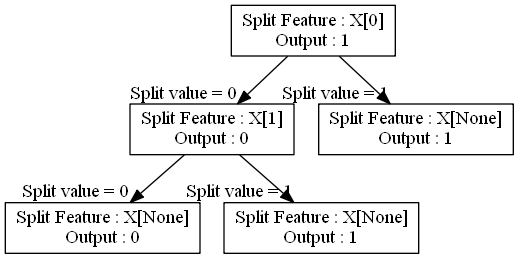

In [6]:
#extracting dot data for decision tree and exporting tree in pdf format
dot_data=clf1.export_tree_pdf(filename="tree_OR.pdf")
#generating graph fromdot data
graph = pydotplus.graph_from_dot_data(dot_data)
#print(dot_data)
#print image of graph in png format
Image(graph.create_png())

# Using Inbuilt sklearn Decision Tree Classifier 
## On 2 Input or gate,
### Thereby fitting the training data to generate the prediction and graph of decision tree.Hence, findng the score.

In [7]:
# Using the inbuilt sklearn Decision tree and comparing it with our model on the same dataset
import sklearn.tree
#clf2 represents class DecisionTreeClassifier with criterion entropy
clf2 = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
#fitting x and y
clf2.fit(x,y)
#predicting value of y using x data
Y_pred2 = clf2.predict(x)
#generating score of prediction of y using x data and comparing it y
print("Predictions",Y_pred2)
sklearn_score = clf2.score(x,y)

#comparing scores
print("Score of our model :",our_score)
print("Score of inbuilt sklearn's decision tree on the same data :",sklearn_score)

Predictions [0 1 1 1]
Score of our model : 1.0
Score of inbuilt sklearn's decision tree on the same data : 1.0


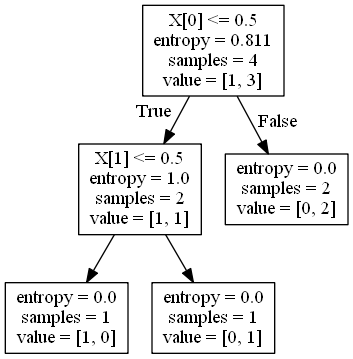

In [8]:
#extract dot data
dot_data = export_graphviz(clf2, out_file=None)
#draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
#show graph
Image(graph.create_png())

# Using  DecisionTreeClassifier_SplitOnUniqueValues 
## On Iris dataset, 
### Thereby fitting the training data to generate the prediction and graph of decision tree.Hence, findng the score.

In [9]:
#importing Iris dataset from sklearn datasets
from sklearn import datasets
iris=datasets.load_iris()
#Extracting iris data as X and iris target as Y
X=iris.data[:,:]
Y=iris.target
#to reduce the unique values of a feature,converting all the float values to int 
for i in range(len(X)):
    for j in range(len(X[0])):
        X[i][j]=int(X[i][j])

#clf3 represents class DecisionTreeClassifier_SplitOnUniqueValues
clf3 = DecisionTreeClassifier_SplitOnUniqueValues() 
#fit X and Y in decision tree with criterion Gini Index
clf3.fit(X,Y,criterion='gini_index')

Level 0
Count of 0 = 50
Count of 1 = 50
Count of 2 = 50
Current Gini Index is = 0.6666666666666665
Splitting on feature  X[2] with gini gain 0.5726866002214838

Level 1
Count of 0 = 50
Count of 1 = 0
Count of 2 = 0
Current Gini Index is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 11
Count of 2 = 0
Current Gini Index is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 37
Count of 2 = 6
Current Gini Index is = 0.24012979989183347
Splitting on feature  X[0] with gini gain 0.040246078961600845

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Gini Index is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 15
Count of 2 = 1
Current Gini Index is = 0.1171875
Splitting on feature  X[3] with gini gain 0.1171875

Level 3
Count of 0 = 0
Count of 1 = 15
Count of 2 = 0
Current Gini Index is =  0.0
Reached leaf Node

Level 3
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Gini Index is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count

In [10]:
#predict the output for X using the decision tree
Y_pred3 = clf3.predict(X)
print("Predictions : ",Y_pred3)
print()
#generating score by comparing value of 'prediction of Y using X data' and 'Y'
our_score = clf3.score(X,Y)
#score on training data
print("Score :",our_score) 
print()

Predictions :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2]

Score : 0.96



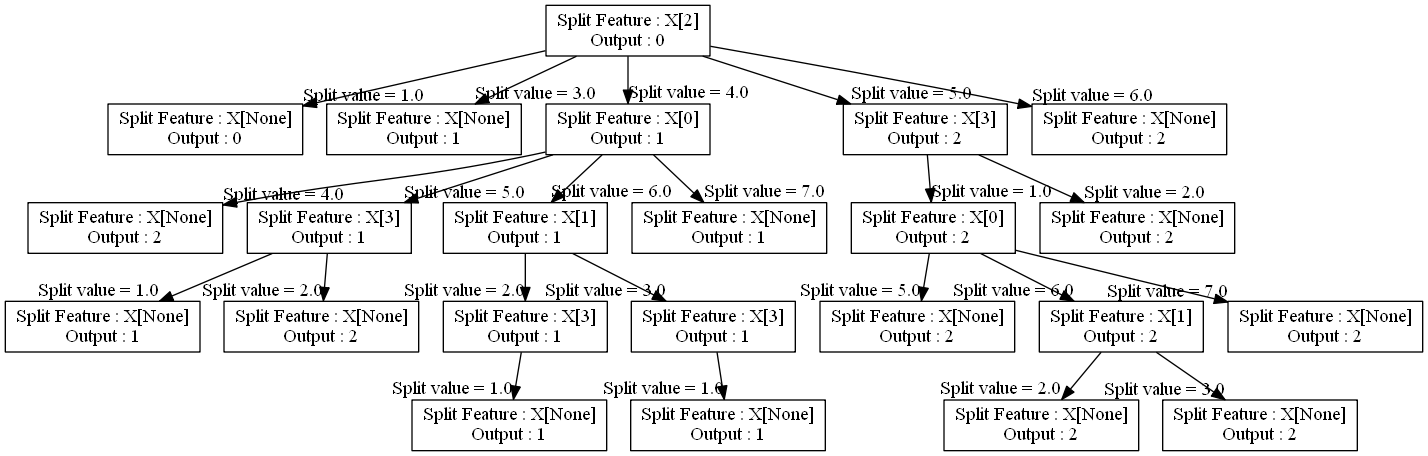

In [11]:
#extracting dot data for decision tree and exporting tree in pdf format
dot_data=clf3.export_tree_pdf(filename="iris.pdf")
#generating graph fromdot data
graph = pydotplus.graph_from_dot_data(dot_data)
#print(dot_data)
#print image of graph in png format
Image(graph.create_png())

# Using Inbuilt sklearn Decision Tree Classifier 
## On Iris dataset, 
### Thereby fitting the training data to generate the prediction and graph of decision tree.Hence, findng the score.

In [13]:
#Using the inbuilt sklearn Decision tree and comparing it with our model on the same dataset
import sklearn.tree
#clf4 represents class DecisionTreeClassifier with default criterion gini
clf4 = sklearn.tree.DecisionTreeClassifier()
#fitting X and Y
clf4.fit(X,Y)
#predicting value of Y using X data
Y_pred4 = clf4.predict(X)
print("Predictions",Y_pred4)
#generating score of prediction of Y using X data and comparing it Y
sklearn_score = clf4.score(X,Y)

#comparing scores
print("Score of our model :",our_score)
print("Score of inbuilt sklearn's decision tree on the same data :",sklearn_score)

Predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2]
Score of our model : 0.96
Score of inbuilt sklearn's decision tree on the same data : 0.96


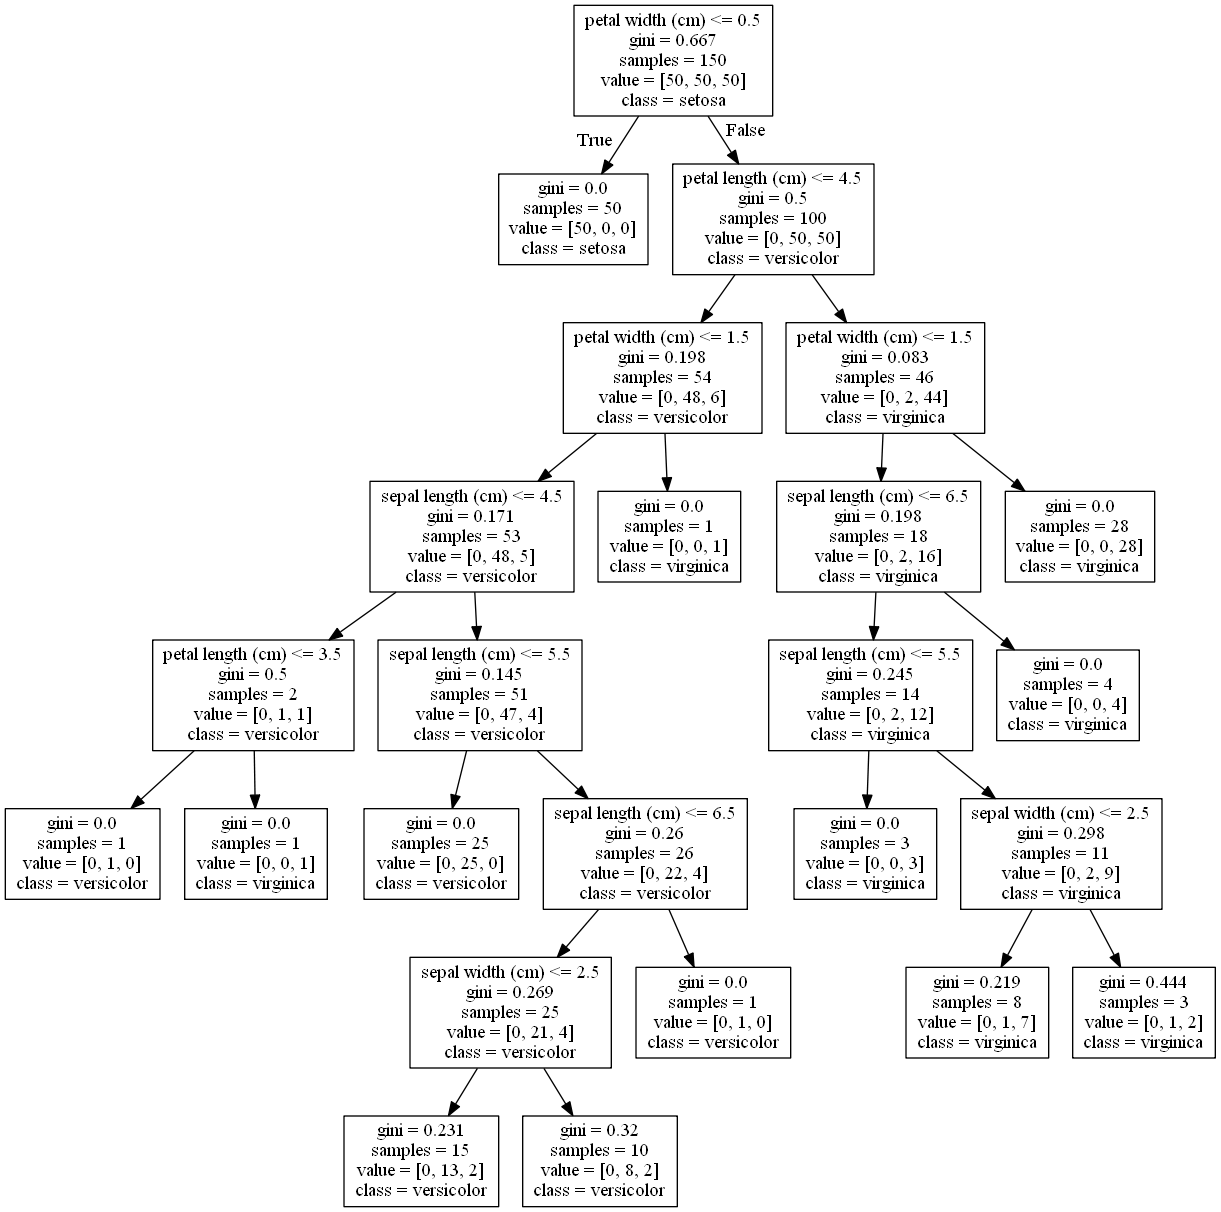

In [14]:
#extract dot data
dot_data = export_graphviz(clf4, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names)
#draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
#show graph
Image(graph.create_png())